## My first attempt at making "tutorial" (kind-of) notes 
- explaining why I took certain steps and documenting thought process

In [1]:
from platform import python_version
print(python_version())
#just checking

3.6.6


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

#To ignore warnings, to display warning only once use 'once', 
#change it to 'default' to get default settings
warnings.filterwarnings('ignore') 

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
# Consiously importing modules/methods when required 

In [4]:
datalake = '../input/data.csv'
dataset = pd.read_csv(datalake)

In [5]:
dataset.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


In [6]:
#removing 'id' and 'Unnamed: 32' columns and
# copying X and target label 'diagnosis' to seperate DataFrames for analysis
dataset.drop(['id','Unnamed: 32'], axis=1, inplace = True) #removing from dataset directly
X_data = dataset.drop('diagnosis', axis = 1)
Y_data = dataset.diagnosis #note that it becomes a pandas Series object

In [7]:
X_data.head(2) #checking if we have it as required

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [8]:
Y_data.head(2)

0    M
1    M
Name: diagnosis, dtype: object

In [9]:
#checking if any null values in entire dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 n

- Total 569 datapoints(entries), 30 features(float), 1 target(object) ***can cross verify with dataset.shape***
- No missing/null values found
- no objects found apart from target_col - diagnosis; ***i.e we can directly proceed with analysis of X without encoding***  


In [10]:
#converting Y to machine understandable language i.e numbers
classes = list(Y_data.unique()) #get list of unique classes
values = [1 if x=='M' else 0 for x in classes] # assign corresponding values for classes
print('Unique Classes : {}'.format(classes))
print('Respective values assigned : {}'.format(values))

Unique Classes : ['M', 'B']
Respective values assigned : [1, 0]


## As we are trying to predict if cancer is detected, I assigned 1 to Malignant class (M)

It is general convention, that the object/class to-be/if detected to corresponds to 1; we can proceed the other way also.

### In Machine learning if we have multi-class we can use one-vs-all approach; for Neural networks changing neurons in o/p layer should be enough

In [11]:
# assign values to classes and update dataset
Y_data = Y_data.map(dict(zip(classes, values)))
Y_data.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

# Present data is valid to fit any model, so we will first try to get a baseline estimate before proceeding with data analysis and proceed on to other models final model

### As this is a classification model I take Simple Linear Classifier (Logistic Regression) to be my baseline model

# Modeling Logistic Regression

In [12]:
#import required modules
from sklearn.linear_model import LogisticRegression

#used below metrics from sklearn.metrics
    # accuracy_score
    # confusion_matrix
    # precision_score
    # recall_score

In [13]:
seed = 2913
val_ratio = 0.3 
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data, test_size = val_ratio, random_state = seed)
baseline_classifier = LogisticRegression()
baseline_classifier.fit(X_train,Y_train)  #fitting the data to model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
y_pred = baseline_classifier.predict(X_test)    #predecting with test cases
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy of baseline classifer (rounded to 3 digits) : ",round(accuracy,3))

Accuracy of basline classifer (rounded to 3 digits) :  0.959


In [15]:
print(confusion_matrix(Y_test,y_pred))

[[107   3]
 [  4  57]]


In [16]:
tn, fp, fn, tp = confusion_matrix(Y_test,y_pred).flatten() #converting from 2x2 array to a single row array
print ('tn, fp, fn, tp : ', (tn, fp, fn, tp))
print('Precision : ', precision_score(Y_test,y_pred))
print('Sensitivity/Recall(tp rate) : ', recall_score(Y_test,y_pred))

tn, fp, fn, tp :  (107, 3, 4, 57)
Precision :  0.95
Sensitivity/Recall(tp rate) :  0.9344262295081968


## Results 
* Baseline accuracy is around 96% which is decent
* 4 False negatives i.e model predicted no, but they actually do have the disease
* 3 False postivies i.e when the model predicted yes but don't have the disease
* Precision is 0.95, which implies when model predicts yes, only 95% of the time it is correct
* From sensitivity, we can observere that when it's actually yes(Malignant), only ***93%*** i.e 93 of 100 times does the model predict yes



## **We have a baseline estimate, we now do some data analysis, feature engineering and feature selection  to see if we can improve results/predictions**

# Check if the data is skewed
> **i.e if any of the class is under/over-represented**

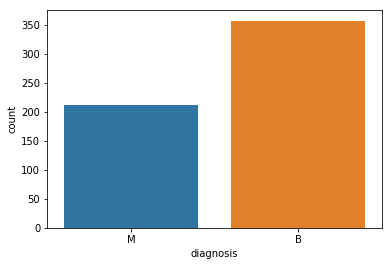

In [17]:
# Checking visually using count plot

sns.countplot(dataset['diagnosis'],label="Count")

In [18]:
# finding respective class count and their percentage wrt to total values
classes, count = np.unique(dataset['diagnosis'].values,return_counts=True)
for cls,val in zip(classes, count):
    print('No. of occurences {}'.format(val))
    print('{0} accounts for {1:.2f}% of total values\n'.format(cls, round(100*val/count.sum(),3)))

print('Total values : {}'.format(dataset['diagnosis'].value_counts().sum()))

No. of occurences 357
B accounts for 62.74% of total values

No. of occurences 212
M accounts for 37.26% of total values

Total values : 569


## It can be observed that there are not much class imbalance, we proceed with our analysis
* **If data is suffering from imbalance, we might have do upsampling or downsampling **

# Checking for outliers
We can check outliers by
- Statistics methods 
    - using Z-score
- Quartile based 
    - using Interquartile range (IQR Score)
- Clustering based 
    - usually using kMeans clustering

We will use visualizations when necessary

I usually use Z score first and if necessary proceed with IQR

>Z score is number of standard deviations by which the value of an observation or data point is above the mean value
    >> i.e Z score = (Observation — Mean)/Standard Deviation
    
    General assumption is that usually all data will follow normal(gaussian) distribution and most of the data(>99%) lies in 3 SD range
    
 > IQR is based on upper and lower bounds arrived based on 1st quartile q1 and 3rd quartile q3 values
         
     IQR = q3 - q1
     Lower bound = q1 - 1.5 * iqr
     Upper bound = q3 + 1.5 * iqr
     
     data not inside the bound are considered as outliers


## Using Z Score

In [21]:
z_score = 3
outliers = X_data < X_data.mean() + (z_score * X_data.std())

In [22]:
# Columns wise datapoints which are outside 3SD, top 15 columns
X_data[outliers].isnull().sum().sort_values(ascending=False).head(15)

compactness_se             12
symmetry_se                11
compactness_worst          10
area_worst                 10
fractal_dimension_se       10
fractal_dimension_worst     9
symmetry_worst              9
compactness_mean            9
concavity_mean              9
texture_se                  9
area_mean                   8
perimeter_se                8
perimeter_mean              7
fractal_dimension_mean      7
radius_se                   7
dtype: int64

In [24]:
# top 10 rows where datapoints outside 3 S.D and the outliers count in each row
X_data[outliers].isnull().sum(axis=1).sort_values(ascending=False).head(10)

122    15
461    11
3       8
352     8
212     7
180     7
82      7
108     6
152     6
503     6
dtype: int64

In [28]:
#total outliers in the data
X_data[outliers].isnull().sum().sum()

210

In [31]:
# top 10 rows contribution to total sum
X_data[outliers].isnull().sum(axis=1).sort_values(ascending=False).head(10).sum()

81

We can see that total outliers in 3SD boundary are 210 (out of 569*30 points which accounts for less than a percent), and around 40% i.e 81 data points are from 10 rows, we can proceed with removing these observations(rows). However because I think we have limited observations, I'll also check with IQR

## Using IQR score

In [57]:
#calculating 25, 75 percentile and calculating iqr, lowerbound and upperbound
q1 = X_data.quantile(0.25)
q3 = X_data.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [58]:
display = pd.concat([q1,q3,iqr,lower_bound, upper_bound],axis=1)
display.columns=['Q1','Q3','IQR','Lower bound', 'Upper bound']
display

,Q1,Q3,IQR,Lower bound,Upper bound
radius_mean,11.700000,15.780000,4.080000,5.580000,21.900000
texture_mean,16.170000,21.800000,5.630000,7.725000,30.245000
perimeter_mean,75.170000,104.100000,28.930000,31.775000,147.495000
area_mean,420.300000,782.700000,362.400000,-123.300000,1326.300000
smoothness_mean,0.086370,0.105300,0.018930,0.057975,0.133695
compactness_mean,0.064920,0.130400,0.065480,-0.033300,0.228620
concavity_mean,0.029560,0.130700,0.101140,-0.122150,0.282410
concave points_mean,0.020310,0.074000,0.053690,-0.060225,0.154535
symmetry_mean,0.161900,0.195700,0.033800,0.111200,0.246400
fractal_dimension_mean,0.057700,0.066120,0.008420,0.045070,0.078750


In [69]:
# get outlier data points
(X_data > upper_bound).head(1)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,False,False,False,False,False,True,True,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False


In [70]:
(X_data < lower_bound).head(1)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Feature Selection 

## Correlation - To remove 

# Feature scaling (Data normalization)

It is optional step
- depends on the algorithm/model we plan to implement and on data we use
    - it allows for model to learn\features to contribute relative to their importance rather than their scale

If it is required to change the algorithm, we have check feature scale again

Some algos that require feature scaling:

    Logistic regression
    SVMs
    Perceptrons
    Neural networks
    PCA    
> ***Usually Distance based algos***

Models which do not require:

    Decision trees (and random forests)
    Naive Bayes
  
